In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import subprocess

from ElectionForecasting.src.validation.log_likelihood_scores import evaluate
from ElectionForecasting.src.validation.model_inference import inference_on_historical_data
from ElectionForecasting.src.modelling.DataLoader import DataLoader

from ElectionForecasting.src.root import ROOT_DIR
from ElectionForecasting.src.utils.plotting_utils import plot_log_likelihood

INFO:root:SETTING DATE TO 2023-10-29


In [2]:
data_loader = DataLoader()
y = '2022'
daily_national_results_df, daily_provincial_results_df = inference_on_historical_data(
        y, data_loader, sample_kwargs={}, save=False, show=False
)

INFO:root:Performing inference on the year 2022.


INFO:root:Results will be saved to:
/home/ae_linux/Projects/ElectionForecastingFinal/ElectionForecasting/results/backtesting_results/2023-10-29/2022/plots
INFO:root:Initializing Driver object.
INFO:root:Loading pleans.
INFO:root:Loading state results.
INFO:root:Loading model inputs.
INFO:root:Loading GAM forecasts.
INFO:root:Loading pleans correlations.
INFO:root:Setting random seed to 123.
INFO:root:Building build_modelthe model.
INFO:root:Transforming input data.
INFO:root:Retrieving GAM forecast for 2022.
INFO:root:Performing categorical transformations.
INFO:root:Performing categorical transformations.
INFO:root:Fitting the model.
INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc.sampling.mcmc:NUTS: [alphas, alpha_party_lag_3q, alpha_pop_vote_lag_3q, betas_gdp_lag_3q, betas_inflation

INFO:pymc.sampling.mcmc:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
INFO:root:Running prediction step.
INFO:root:Getting Bayesian update data.
INFO:root:Retrieving GAM forecast for 2022.
INFO:root:Predictive sampling for all regions
INFO:pymc.sampling.forward:Sampling: [observed_vote_share, party_effect_lag_3q, pop_vote_lag_3q]


INFO:root:Preparing observed data for national-level violin plot...
INFO:root:Generating national-level violin plot...
INFO:root:Processing province Cerebrica...
INFO:root:Processing province Cortexia...
INFO:root:Processing province Neuronia...
INFO:root:Processing province Amperville...
INFO:root:Processing province Binaryshire...
INFO:root:Processing province Byteforge Domain...
INFO:root:Processing province Circuiton...
INFO:root:Processing province Electropolis...
INFO:root:Processing province Infinitron Peninsula...
INFO:root:Processing province Infoglen...
INFO:root:Processing province Quantumridge...
INFO:root:Processing province Voltagea...
INFO:root:Violin plots have been generated and saved.
INFO:root:Completed inference on the year 2022.




INFO:root:Equal weighted sum of the log-likelihood scores: -0.86


Dirichlet log-likelihood: -0.8434283579266726


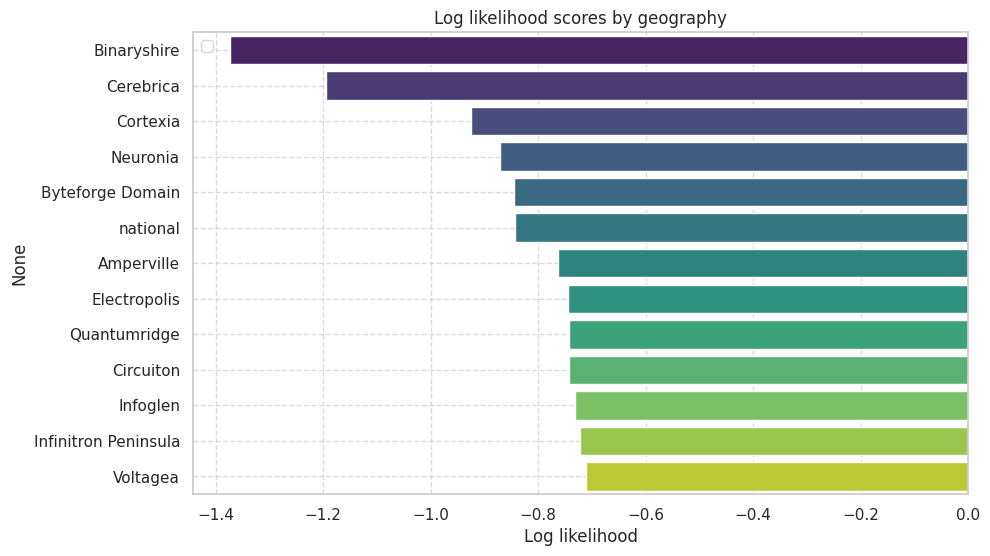

INFO:root:Saving experiment results to:
/home/ae_linux/Projects/ElectionForecastingFinal/ElectionForecasting/results/evaluation/2023-10-29/DefaultModel/2022/LL_mean_score_m_11.21


<Figure size 640x480 with 0 Axes>

In [3]:
election_results_df = pd.read_csv(
    f'{ROOT_DIR}/data/dataland/dataland_election_results_1984_2023.csv'
)
log_likelihoods = evaluate(
    election_results_df, daily_national_results_df,
    daily_provincial_results_df, y, save=True, show=True,
    test_name='DefaultModel'
)

In [4]:
def get_file_hash(file_path):
    # Get the SHA-1 hash of the file
    return subprocess.check_output(['git', 'hash-object', file_path, '-w']).decode('utf-8').strip()

def get_comment_changes(file_path, old_hash):
    # Get the diff between the old hash and current state
    git_diff_output = subprocess.check_output(['git', 'diff', old_hash, file_path]).decode('utf-8')

    # Parse the git diff output to find lines that have been commented or uncommented
    changed_comments = [f'HASHDIFF CHANGES TO FILE {file_path}.',
                        f'OLD HASH: {old_hash}.',
                        "DIFF:"]
    for line in git_diff_output.split('\n'):
        if line.startswith('+ ') or line.startswith('- '):
            changed_comments.append(line)

    return changed_comments

# Load the most recent hash from the previous_git_states/ folder
def get_hash_diff(hash_file, target_file):
    git_states_dir = Path(f'{ROOT_DIR}/previous_git_states/')
    previous_state_file = git_states_dir / hash_file # 'previous_git_states/your_python_file.txt'
    if previous_state_file.exists():
        with open(previous_state_file, 'rb') as f:
            old_hash = f.read().strip()
    else:
        old_hash = None
    new_hash = get_file_hash(target_file)
    comment_changes_to_log = ''
    if old_hash:
        comment_changes_to_log = get_comment_changes(target_file, old_hash)
    # Update the previous state
    with open(previous_state_file, 'w') as f:
        f.write(new_hash)
    return comment_changes_to_log

In [5]:
model_comment_changes_to_log = get_hash_diff(f'DatalandElectionModel.txt', f'{ROOT_DIR}/src/modelling/DatalandElectionModel.py')
date = datetime.today().strftime('%Y-%m-%d')
logs_dir = Path(f'{ROOT_DIR}/logs/{date}/')
logs_dir.mkdir(parents=True, exist_ok=True)
sum_ll_str = f"{log_likelihoods.sum().item():.2f}".replace('-', 'm_')
perf = f'LL_sum_score_{sum_ll_str}'
with open(logs_dir / f'{perf}_hashdiff_driver.txt', 'w') as f:
    f.write("\n".join(model_comment_changes_to_log))